<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/lms_exp2/LMS_EXP_BS2_4TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주가 데이터 예측하기

LG 이노텍 (011070.KS), 하림(136480.KQ), 대한제분(000110)을 가지고 해보겠다.

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## statsmodels 버전 문제
업그레이드 하면 1.13.02인가가 되는데 그 다음에 런타임 중단->다시 실행 필요

In [54]:
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
import sklearn
import statsmodels

def plot_rolling_statistics(timeseries, window=30):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [56]:
data_dir = '/content/drive/MyDrive/colabdata/'
df = pd.read_csv(data_dir+'airline-passengers.csv')
ap=pd.Series(df['Passengers'])

df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [57]:
df = pd.read_csv(data_dir+'136480.KQ.csv')
harim=pd.Series(df['Close'])
df = pd.read_csv(data_dir+'011070.KS.csv')
lgi = pd.Series(df['Close'])
df = pd.read_csv(data_dir+'001130.KS.csv')
dj=pd.Series(df['Close'])
print(harim,lgi,dj, sep='\n\n')

0    2900.0
Name: Close, dtype: float64

0      234500.0
1      233000.0
2      231500.0
3      231500.0
4      225500.0
         ...   
240    345000.0
241    328500.0
242    337000.0
243    341500.0
244    343500.0
Name: Close, Length: 245, dtype: float64

0      173000.0
1      173000.0
2      172500.0
3      174000.0
4      173500.0
         ...   
240    135500.0
241    138500.0
242    139500.0
243    140000.0
244    140000.0
Name: Close, Length: 245, dtype: float64


### 데이터 둘러보기
종가를 다 긁었는데, 250개였던 삼성전자와 비슷하게 245개의 row가 있다. 그런데 하림은 하나 뿐이다. 아마 코스닥이라 그런 것 같다.
(한국거래소)[http://data.krx.co.kr/]에서 새로 다운받았다. 245~250은 1년간 장이 열린 날의 수인 것 같다. 다만 엑셀 최신 포맷으로 줘서 변환을 해야 했다.

In [58]:
df = pd.read_csv(data_dir+'data_5702_20220722.csv')
ts_harim=pd.Series(df['Close'])
print(ts_harim)

0      2900
1      2870
2      2880
3      2885
4      2880
       ... 
242    3200
243    3195
244    3130
245    3205
246    3175
Name: Close, Length: 247, dtype: int64


# 1. 항공사 승객 데이터에 의한 코드 검증
이 노트북은 Aiffel LMS EXP BS2 4. 시계열 데이터에서 주가 세 개 이상 예측해보라고 하여 하는 것이다. 먼저 여기서 분석한 항공사 데이터가 같게 나오는지 테스트해보겠다.

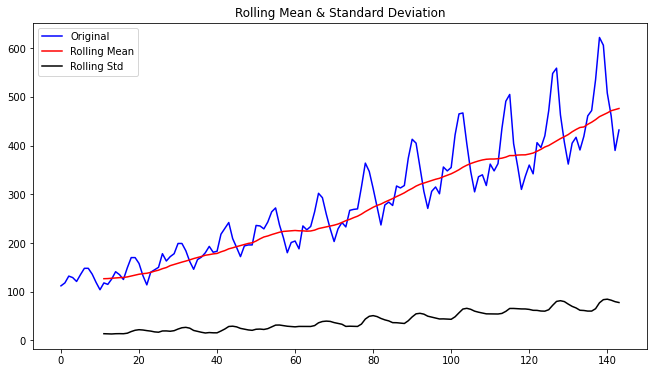

In [59]:
plot_rolling_statistics(ap, window=12)

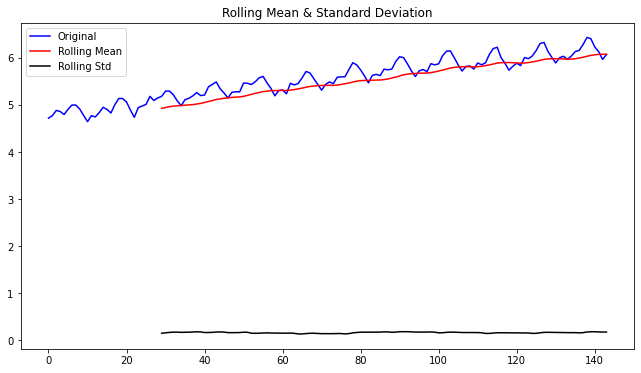

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


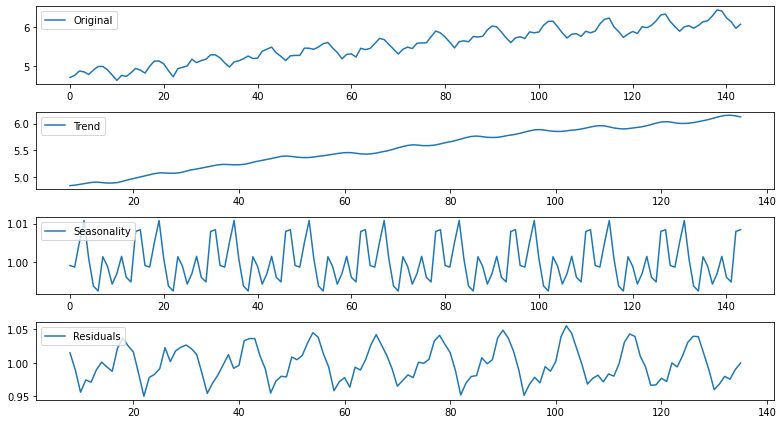

8     1.015116
9     0.989936
10    0.956387
11    0.974669
12    0.971360
Name: resid, dtype: float64
Int64Index([], dtype='int64')
8     1.015116
9     0.989936
10    0.956387
11    0.974669
12    0.971360
Name: resid, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.354110
p-value                          0.000358
#Lags Used                      13.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64
None


In [60]:
ts_log=np.log(ap)
plot_rolling_statistics(ts_log, window=30) #defined at 4-5

#quantitative Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log) #defined at 4-4

#Time Series Decomposition
cperiod=16
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=cperiod)

#copied from 4-6
trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid #original data - trend - seasonality

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
residual.dropna(inplace=True) #drop nan values.
#residual.drop(labels=residual[residual.isna()].index ,inplace=True) #alternate

print(residual.head())
print(residual[residual.isna()].index)
print(residual.head())
print(augmented_dickey_fuller_test(residual))

8      1.015116
9      0.989936
10     0.956387
11     0.974669
12     0.971360
         ...   
131    0.968665
132    0.980025
133    0.975696
134    0.990112
135    0.999837
Name: resid, Length: 128, dtype: float64
False 105 False 23


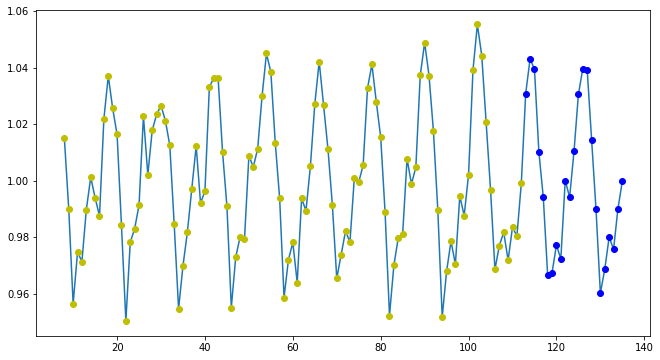

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


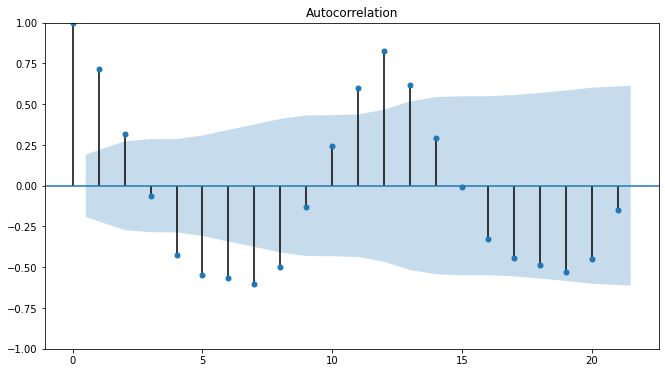

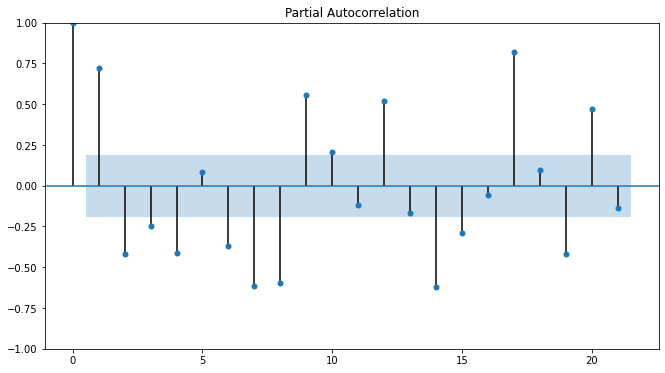

Results of Dickey-Fuller Test:
Test Statistic                 -3.724981
p-value                         0.003775
#Lags Used                     13.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                  -4.354110
p-value                          0.000358
#Lags Used                      13.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64
None
8      1.015116
9      0.989936
10     0.956387
11     0.974669
12     0.971360
         ...   
108    0.981738
109    0.971814
110    0.983596
111    0.980336
112    0.998984
Name: resid, Length: 105, dtype: float64
[-0.02517961 -0.03354869  0.01828168 -0.00330877  0.01831304  0.01152671
 -0.00724695 -0.00648328  0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zero

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  105
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 301.876
Date:                Sun, 24 Jul 2022   AIC                           -589.753
Time:                        16:10:53   BIC                           -571.175
Sample:                             0   HQIC                          -582.225
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   2239.933      0.000       0.999       1.001
ar.L1          0.8472      0.100      8.499      0.000       0.652       1.043
ar.L2          0.4440      0.150      2.964      0.0

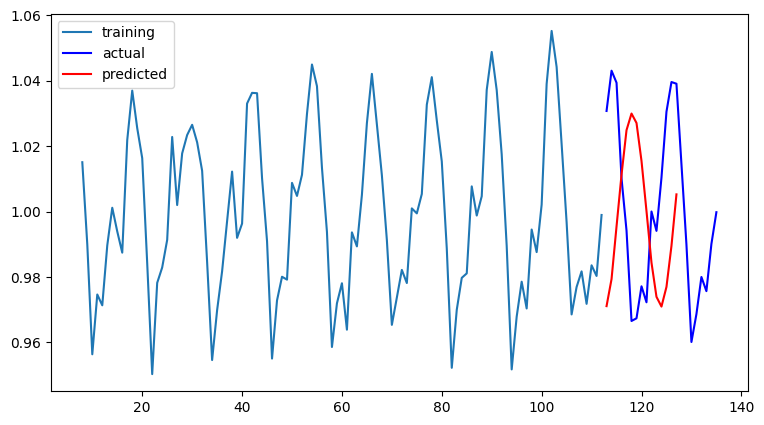

In [61]:

print(residual) #128
train_data, test_data = residual[:105], residual[105:]

print(train_data.isnull().any(),train_data.size,  test_data.isnull().any(),test_data.size)

plt.plot(residual, label='residual data')
plt.plot(train_data, 'yo', label='train_data')
plt.plot(test_data, 'bo', label='test_data')
plt.show()

# plot acf, pacf to decide p, q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data)
plot_pacf(train_data)
plt.show()

#verify p-value of augmented_dickey_fuller_test is small enough (smaller than 0.05 or 0.01)
print(augmented_dickey_fuller_test(train_data))
print(augmented_dickey_fuller_test(residual))

diff1=train_data.values[1:]-train_data.values[:-1]
print(train_data, diff1, sep="\n")

print(augmented_dickey_fuller_test(diff1))

diff2=diff1[1:]-diff1[:-1]
print(augmented_dickey_fuller_test(diff2))
from statsmodels.tsa.arima.model import ARIMA

# copy of 4-8
model = ARIMA(train_data, order=(3, 0, 2)) 
fitted_m = model.fit() 

print(fitted_m.summary())

#copy of 4-8
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf, 12 added

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 
print(fc)
print(fc_series)
# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual')
#plt.plot(residual, label ='residual')
plt.plot(fc_series, c='r',label='predicted')
print(len(fc_series),len(test_data))
plt.legend()
plt.show()

## 1.1. 결과 검증
predicted 데이터를 x축에서 6 정도 당기면 모양이 딱 맞을 것 같아 보이고, predicted 데이터가 train 데이터에서 너무 동떨어져 보입니다. 그래서 결과를 잔뜩 출력시켰습니다. 먼저 train - test데이터가 끊겨 보이는 것은 그냥 기울기가 커서 그런 것으로 잘못된 것은 없어 보입니다. 하지만 fc와 fc-series간의 차이는 납득하기 어렵습니다.

Int64Index([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
            126, 127, 128, 129, 130, 131, 132, 133, 134, 135],
           dtype='int64')
23 23


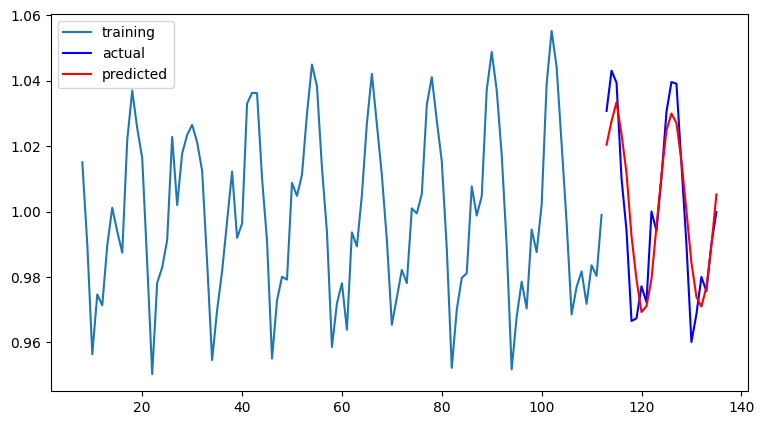

In [62]:

# Make as pandas series
fc_series = pd.Series(fc)   # 예측결과
fc_series.index=test_data.index
print(test_data.index)

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual')
plt.plot(fc_series, c='r',label='predicted')
print(len(fc_series),len(test_data))
plt.legend()
plt.show()


fc_series의 index를 그냥 test_data.index로 덮어씌우니 문제가 해결됐다. pd.Series()에서 무슨 문제가 있었던 것인지 모르겠지만 아무튼 이대로 하겠다.

In [63]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc_series))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc_series))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data),np.exp(fc_series)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_series) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0010431322413472952
MAE:  0.025608512940540184
RMSE:  0.032297557823267306
MAPE: 0.94%


### 1.2. 오차 계산
여러가지 방법으로 오차를 계산했는데, 별 의미가 있어 보이지는 않는다. 예측 범위의 데이터가 약 0.96 ~ 1.04의 아주 좁은 4%정도의 범위에 몰려있기 때문이다. trend, seasonality를 더하는 것은 오차를 오히려 키울 것이고 옳지도 않다. 왜냐하면 그걸 뺀 residual을 가지고 train - test data를 나눴기 때문이다. 그러고 보니 왜 그렇게 했을까? 아무튼 이 방식을 적용해보도록 하겠다.

# 2. 하림 분석
시계열 분석에서 했던 과정을 다시 정리해보자. 
- 데이터를 살펴보고 그냥 할지 log를 취할지 결정
- decompose할지 결정
- ACF, PACF, 차분에서 p, d, q 결정
- ARIMA 모델 학습
- 예측
- 결과 확인

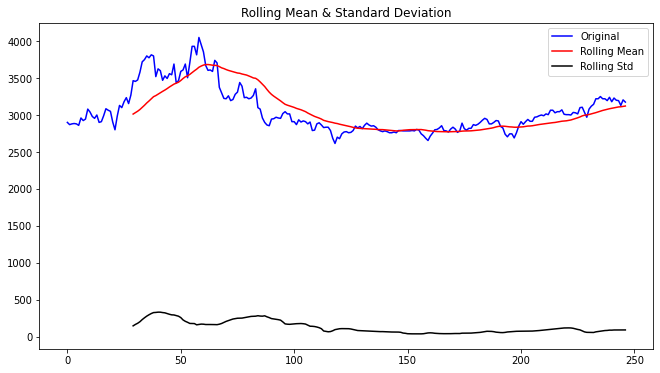

In [64]:
plot_rolling_statistics(ts_harim, window=30)

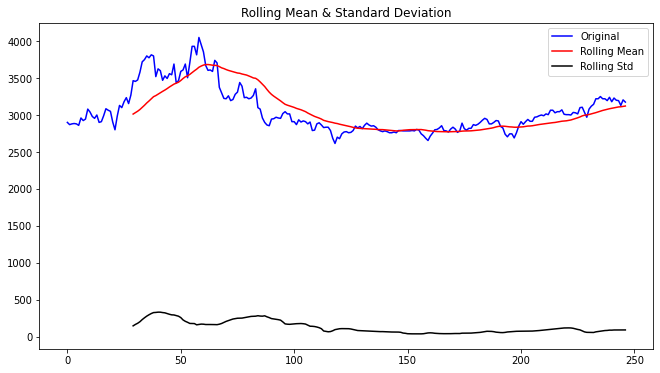

Results of Dickey-Fuller Test:
Test Statistic                  -1.863837
p-value                          0.349260
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


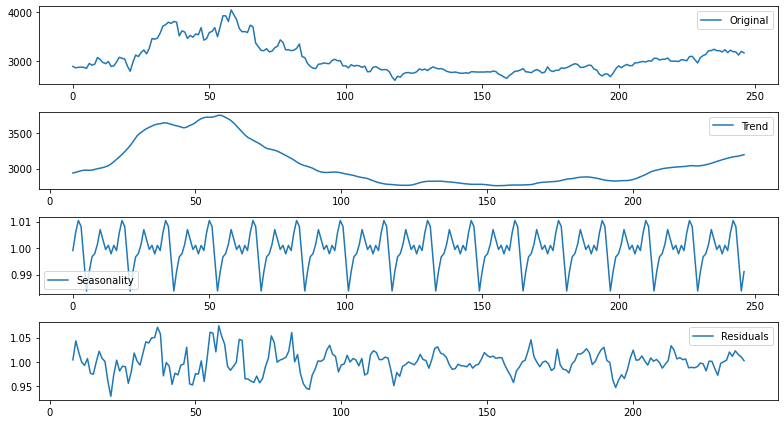

8     1.004343
9     1.043253
10    1.019729
11    0.999631
12    0.993004
Name: resid, dtype: float64
Int64Index([], dtype='int64')
8     1.004343
9     1.043253
10    1.019729
11    0.999631
12    0.993004
Name: resid, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.281989e+00
p-value                        1.492092e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64
None


In [65]:
plot_rolling_statistics(ts_harim, window=30) #defined at 4-5

#quantitative Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_harim) #defined at 4-4

#Time Series Decomposition
cperiod=16
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_harim, model='multiplicative', period=cperiod)

#copied from 4-6
trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid #original data - trend - seasonality

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_harim, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
residual.dropna(inplace=True) #drop nan values.
#residual.drop(labels=residual[residual.isna()].index ,inplace=True) #alternate

print(residual.head())
print(residual[residual.isna()].index)
print(residual.head())
print(augmented_dickey_fuller_test(residual))

False 207 False 24


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


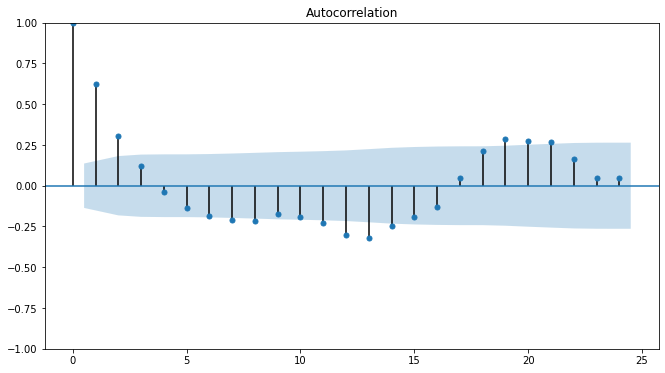

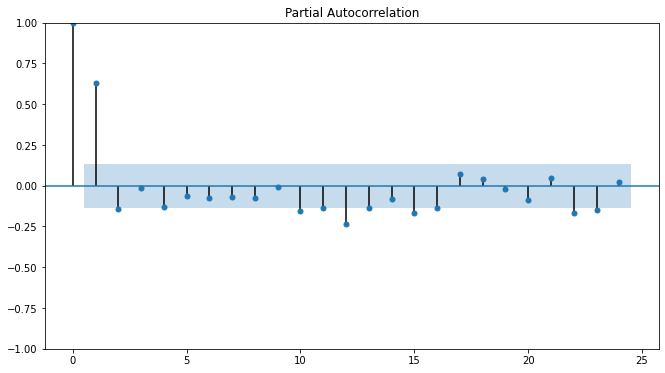

Results of Dickey-Fuller Test:
Test Statistic                -6.725265e+00
p-value                        3.402328e-09
#Lags Used                     1.500000e+01
Number of Observations Used    1.910000e+02
Critical Value (1%)           -3.465059e+00
Critical Value (5%)           -2.876794e+00
Critical Value (10%)          -2.574901e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -7.357393e+00
p-value                        9.699372e-11
#Lags Used                     1.500000e+01
Number of Observations Used    1.900000e+02
Critical Value (1%)           -3.465244e+00
Critical Value (5%)           -2.876875e+00
Critical Value (10%)          -2.574945e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -9.260397e+00
p-value                        1.412214e-15
#Lags Used                     9.000000e+00
Number of Observations Used    1.950000e+02
Critical Value (1%)           -3.464337e+00
Critical Value (5%)           -

In [66]:
train_data, test_data = residual[:int(len(residual)*0.9)], residual[int(len(residual)*0.9):]

print(train_data.isnull().any(),train_data.size,  test_data.isnull().any(),test_data.size)
# plot acf, pacf to decide p, q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data)
plot_pacf(train_data)
plt.show()

#verify p-value of augmented_dickey_fuller_test is small enough (smaller than 0.05 or 0.01)
print(augmented_dickey_fuller_test(train_data))

diff1=train_data.values[1:]-train_data.values[:-1]

print(augmented_dickey_fuller_test(diff1))

diff2=diff1[1:]-diff1[:-1]
print(augmented_dickey_fuller_test(diff2))



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.d

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  207
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 528.497
Date:                Sun, 24 Jul 2022   AIC                          -1042.995
Time:                        16:10:56   BIC                          -1019.666
Sample:                             0   HQIC                         -1033.561
                                - 207                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9997      0.001   1115.311      0.000       0.998       1.001
ar.L1          1.4212      0.126     11.281      0.000       1.174       1.668
ar.L2         -0.5652      0.121     -4.659      0.0

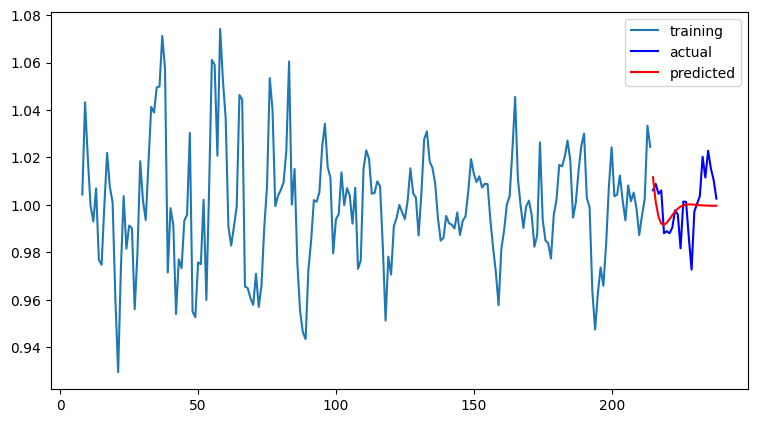

In [67]:
from statsmodels.tsa.arima.model import ARIMA

# copy of 4-8
model = ARIMA(train_data, order=(2,0,3)) 
fitted_m = model.fit() 

print(fitted_m.summary())

#copy of 4-8
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf, 12 added

# Make as pandas series
fc_series = pd.Series(fc) 
fc_series.index=test_data.index

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual')
#plt.plot(residual, label ='residual')
plt.plot(fc_series, c='r',label='predicted')
print(len(fc_series),len(test_data))
plt.legend()
plt.show()

In [68]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc_series))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc_series))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data),np.exp(fc_series)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_series) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0009937322951138678
MAE:  0.02403303955996409
RMSE:  0.03152351971328499
MAPE: 0.88%


### 2. 1. 하림 예측 결과
(p,d,q)=(4,0,2)일 때도 그럴싸한 그래프가 그려졌지만 PACF를 보고 p=2에서 적당한 조합을 찾아보았다. 중간에 가격이 조금 올라가긴 하지만 주가가 대체로 큰 범위에서 늘어나지 않기 떄문에 log를 취하지 않았다.
오차는 역시 엄청 작게 나왔다.

# 3. 대한제분

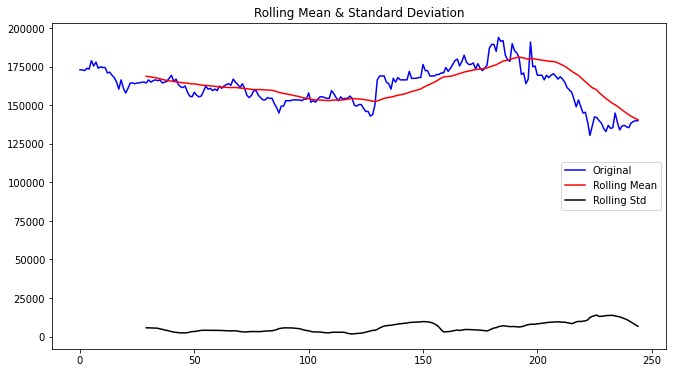

In [69]:
plot_rolling_statistics(dj, window=30)

Results of Dickey-Fuller Test:
Test Statistic                  -1.770123
p-value                          0.395393
#Lags Used                       1.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


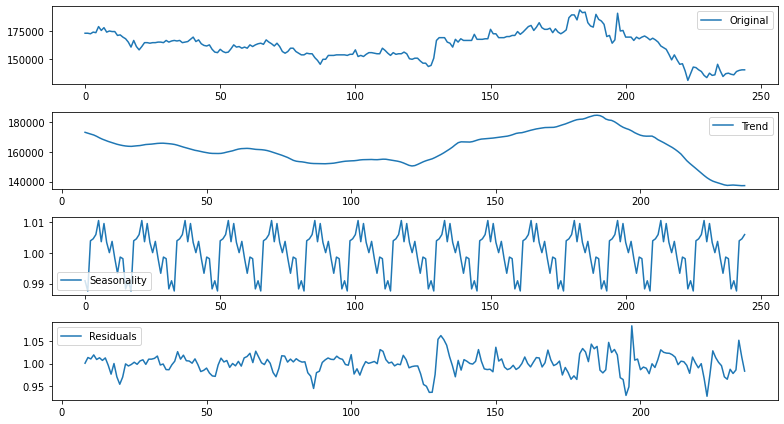

8     1.000801
9     1.013623
10    1.010435
11    1.019519
12    1.009177
Name: resid, dtype: float64
Int64Index([], dtype='int64')
8     1.000801
9     1.013623
10    1.010435
11    1.019519
12    1.009177
Name: resid, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.086390e+00
p-value                        1.416121e-12
#Lags Used                     3.000000e+00
Number of Observations Used    2.250000e+02
Critical Value (1%)           -3.459752e+00
Critical Value (5%)           -2.874473e+00
Critical Value (10%)          -2.573663e+00
dtype: float64
None


In [70]:
#quantitative Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(dj) #defined at 4-4

#Time Series Decomposition
cperiod=16
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dj, model='multiplicative', period=cperiod)

#copied from 4-6
trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid #original data - trend - seasonality

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(dj, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
residual.dropna(inplace=True) #drop nan values.
#residual.drop(labels=residual[residual.isna()].index ,inplace=True) #alternate

print(residual.head())
print(residual[residual.isna()].index)
print(residual.head())
print(augmented_dickey_fuller_test(residual))

False 206 False 23


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


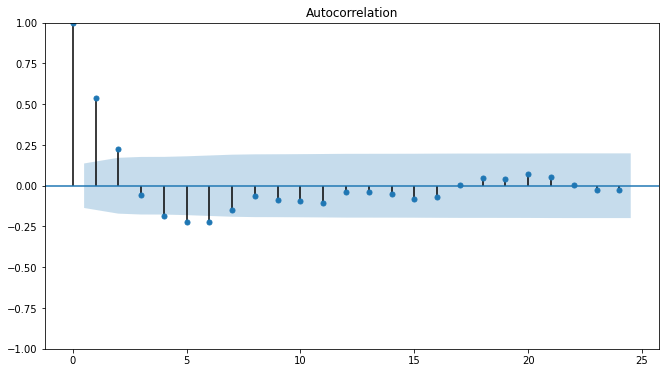

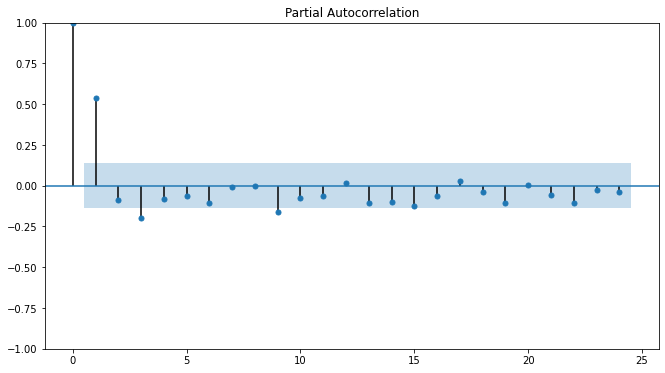

Results of Dickey-Fuller Test:
Test Statistic                -8.050680e+00
p-value                        1.745459e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -7.541845e+00
p-value                        3.361984e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.940000e+02
Critical Value (1%)           -3.464515e+00
Critical Value (5%)           -2.876556e+00
Critical Value (10%)          -2.574775e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -8.324804e+00
p-value                        3.493847e-13
#Lags Used                     1.200000e+01
Number of Observations Used    1.910000e+02
Critical Value (1%)           -3.465059e+00
Critical Value (5%)           -

In [71]:
train_data, test_data = residual[:int(len(residual)*0.9)], residual[int(len(residual)*0.9):]

print(train_data.isnull().any(),train_data.size,  test_data.isnull().any(),test_data.size)
# plot acf, pacf to decide p, q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data)
plot_pacf(train_data)
plt.show()

#verify p-value of augmented_dickey_fuller_test is small enough (smaller than 0.05 or 0.01)
print(augmented_dickey_fuller_test(train_data))

diff1=train_data.values[1:]-train_data.values[:-1]

print(augmented_dickey_fuller_test(diff1))

diff2=diff1[1:]-diff1[:-1]
print(augmented_dickey_fuller_test(diff2))



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.d

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  206
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 542.068
Date:                Sun, 24 Jul 2022   AIC                          -1072.135
Time:                        16:10:58   BIC                          -1052.168
Sample:                             0   HQIC                         -1064.060
                                - 206                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9999      0.000   2627.349      0.000       0.999       1.001
ar.L1          1.5149      0.079     19.089      0.000       1.359       1.670
ar.L2         -0.6294      0.085     -7.441      0.0

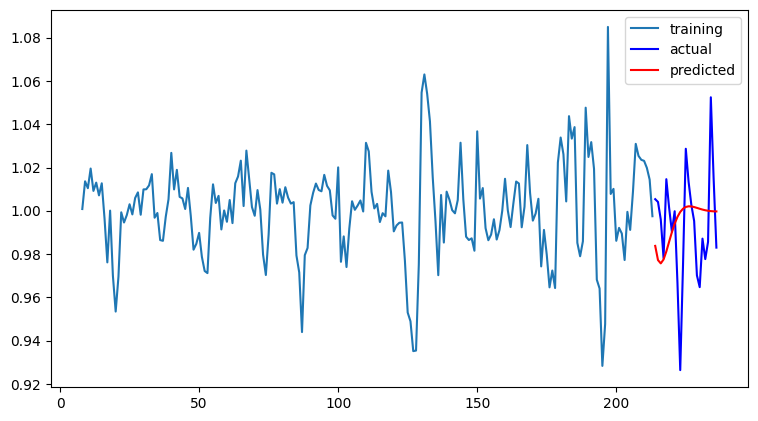

In [72]:
from statsmodels.tsa.arima.model import ARIMA

# copy of 4-8
model = ARIMA(train_data, order=(2,0,2)) 
fitted_m = model.fit() 

print(fitted_m.summary())

#copy of 4-8
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf, 12 added

# Make as pandas series
fc_series = pd.Series(fc) 
fc_series.index=test_data.index

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual')
#plt.plot(residual, label ='residual')
plt.plot(fc_series, c='r',label='predicted')
print(len(fc_series),len(test_data))
plt.legend()
plt.show()

In [73]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc_series))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc_series))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data),np.exp(fc_series)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_series) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.00543718874901196
MAE:  0.058846713942465566
RMSE:  0.07373729550920592
MAPE: 2.19%


### 대한제분 오차
MAPE값이 2.19%로 매우 낮게 나왔지만, 그래프를 보면 '안전하고 재미없는 결과'가 나왔다. 저런 결과에서는 수익을 얻기 힘들 것이다.

# LG 이노텍

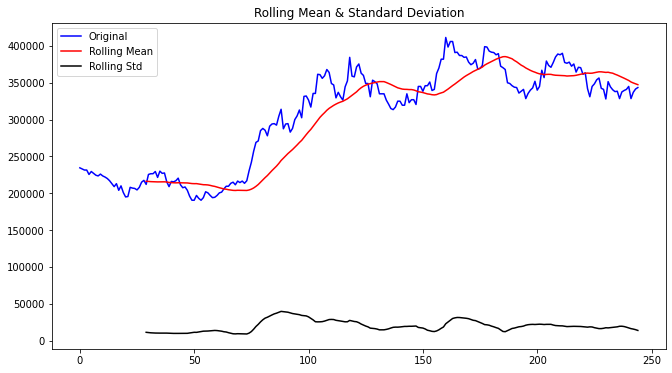

In [74]:
plot_rolling_statistics(lgi, window=30)

Results of Dickey-Fuller Test:
Test Statistic                  -1.140698
p-value                          0.698572
#Lags Used                       1.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


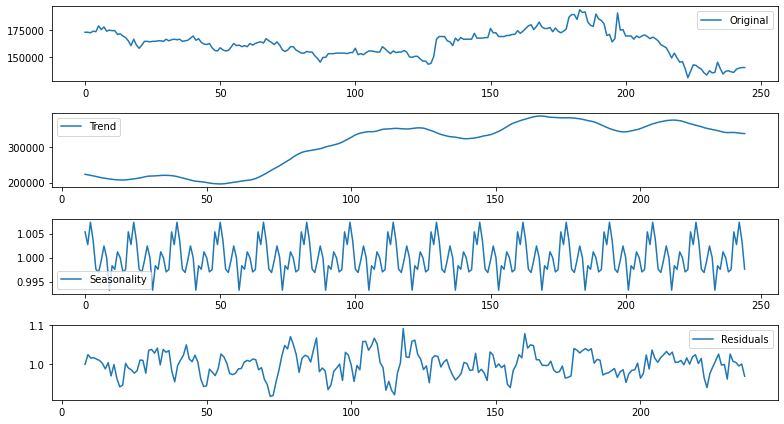

8     0.998830
9     1.024101
10    1.014824
11    1.016245
12    1.012254
Name: resid, dtype: float64
Int64Index([], dtype='int64')
8     0.998830
9     1.024101
10    1.014824
11    1.016245
12    1.012254
Name: resid, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.941122e+00
p-value                        2.259709e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64
None


In [75]:
#quantitative Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(lgi) #defined at 4-4

#Time Series Decomposition
cperiod=16
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(lgi, model='multiplicative', period=cperiod)

#copied from 4-6
trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid #original data - trend - seasonality

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(dj, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
residual.dropna(inplace=True) #drop nan values.
#residual.drop(labels=residual[residual.isna()].index ,inplace=True) #alternate

print(residual.head())
print(residual[residual.isna()].index)
print(residual.head())
print(augmented_dickey_fuller_test(residual))

False 206 False 23


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


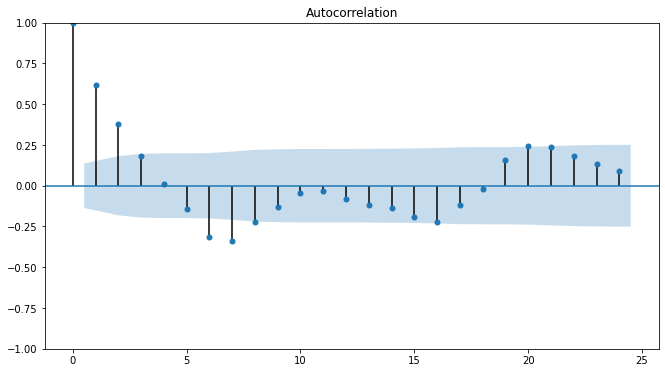

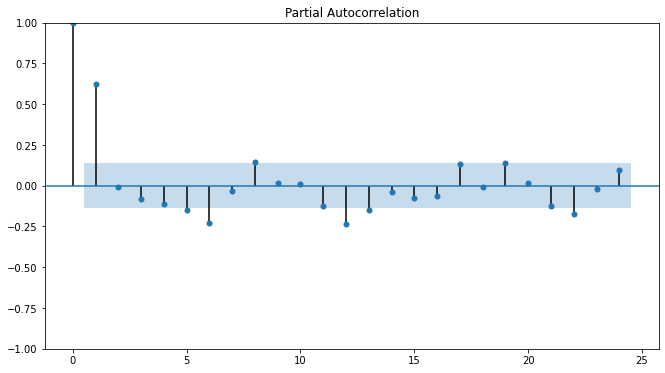

Results of Dickey-Fuller Test:
Test Statistic                -5.994290e+00
p-value                        1.716235e-07
#Lags Used                     1.200000e+01
Number of Observations Used    1.930000e+02
Critical Value (1%)           -3.464694e+00
Critical Value (5%)           -2.876635e+00
Critical Value (10%)          -2.574816e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -6.777307e+00
p-value                        2.551362e-09
#Lags Used                     1.500000e+01
Number of Observations Used    1.890000e+02
Critical Value (1%)           -3.465431e+00
Critical Value (5%)           -2.876957e+00
Critical Value (10%)          -2.574988e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -9.477910e+00
p-value                        3.943845e-16
#Lags Used                     1.000000e+01
Number of Observations Used    1.930000e+02
Critical Value (1%)           -3.464694e+00
Critical Value (5%)           -

In [76]:
train_data, test_data = residual[:int(len(residual)*0.9)], residual[int(len(residual)*0.9):]

print(train_data.isnull().any(),train_data.size,  test_data.isnull().any(),test_data.size)
# plot acf, pacf to decide p, q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data)
plot_pacf(train_data)
plt.show()

#verify p-value of augmented_dickey_fuller_test is small enough (smaller than 0.05 or 0.01)
print(augmented_dickey_fuller_test(train_data))

diff1=train_data.values[1:]-train_data.values[:-1]

print(augmented_dickey_fuller_test(diff1))

diff2=diff1[1:]-diff1[:-1]
print(augmented_dickey_fuller_test(diff2))



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zero

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  206
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 467.469
Date:                Sun, 24 Jul 2022   AIC                           -922.938
Time:                        16:11:00   BIC                           -902.970
Sample:                             0   HQIC                          -914.862
                                - 206                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9942      0.003    362.965      0.000       0.989       1.000
ar.L1          1.5126      0.105     14.460      0.000       1.308       1.718
ar.L2         -0.6713      0.077     -8.677      0.0

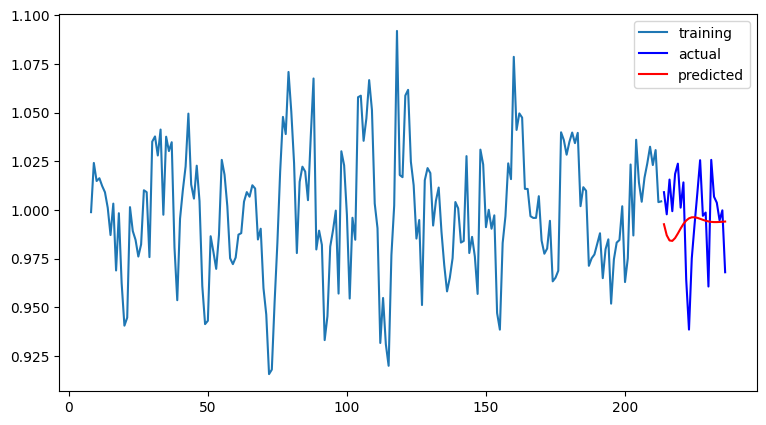

In [77]:
from statsmodels.tsa.arima.model import ARIMA

# copy of 4-8
model = ARIMA(train_data, order=(2,0,2)) 
fitted_m = model.fit() 

print(fitted_m.summary())

#copy of 4-8
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf, 12 added

# Make as pandas series
fc_series = pd.Series(fc) 
fc_series.index=test_data.index

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual')
#plt.plot(residual, label ='residual')
plt.plot(fc_series, c='r',label='predicted')
print(len(fc_series),len(test_data))
plt.legend()
plt.show()

In [78]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc_series))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc_series))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data),np.exp(fc_series)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_series) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.004212723860957124
MAE:  0.05362996249692512
RMSE:  0.06490549946620182
MAPE: 1.99%


### LG 이노텍 예측 결과
역시 이전과 달리 '재미없는'결과가 나왔다. 구간의 시작과 끝에서 상당한 주가 상승이 있었던 종목이라 log를 취할까 말까 고민하다가 그냥 두었지만 maple값이 그렇게 크게 나오지는 않았다.

# 5. 회고
개인적으로 심란한 주제였다. 주가를 예측하는 것이 불가능하다는 결론을 너무 많이 접했고, 너무 확고해 보였다. 그리고 이 오차에는 조금씩 벌다가 크게 잃을 가능성이 제대로 반영되지 않고 있는 것 같다.
 생각나는 대로 종목을 골라보았는데, 의도가 잘 맞지는 않았다. 하림의 경우 조류독감 등으로 연단위의 주기적인 등락을 보인다는 것이 잘 알려진 종목이다. 하지만 여기서 다루는 것은 1년 단위의 데이터라 그것이 반영될 가능성이 없었다. 대한제분 역시 비슷하다. 대한제분은 IMF 당시 아버지의 평생 수익률에 막대한 타격을 입힌 종목이다. LG이노텍은 작년 친구의 추천으로 샀던 종목이다. 조금 올랐다고 팔았는데 많이 올라서 지금 주가를 보면 배가 아프다.
  기상 모델 같은 것이었다면 좀 더 재미있게 할 수 있었을 것 같다. 그리고 이걸 하던 와중에 exploration node2의 제출을 깜박해서 내지 못했다. 정해진 일정도 제대로 소화하지 못하는데 미래를 예상하는게 무슨 소용인가 하는 생각이 들 수 밖에 없었다.